# 粒子スムーザー（KSとの比較）

データとしては，data/rhine-river-near-basle-switzerla.csvを用いる．

In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

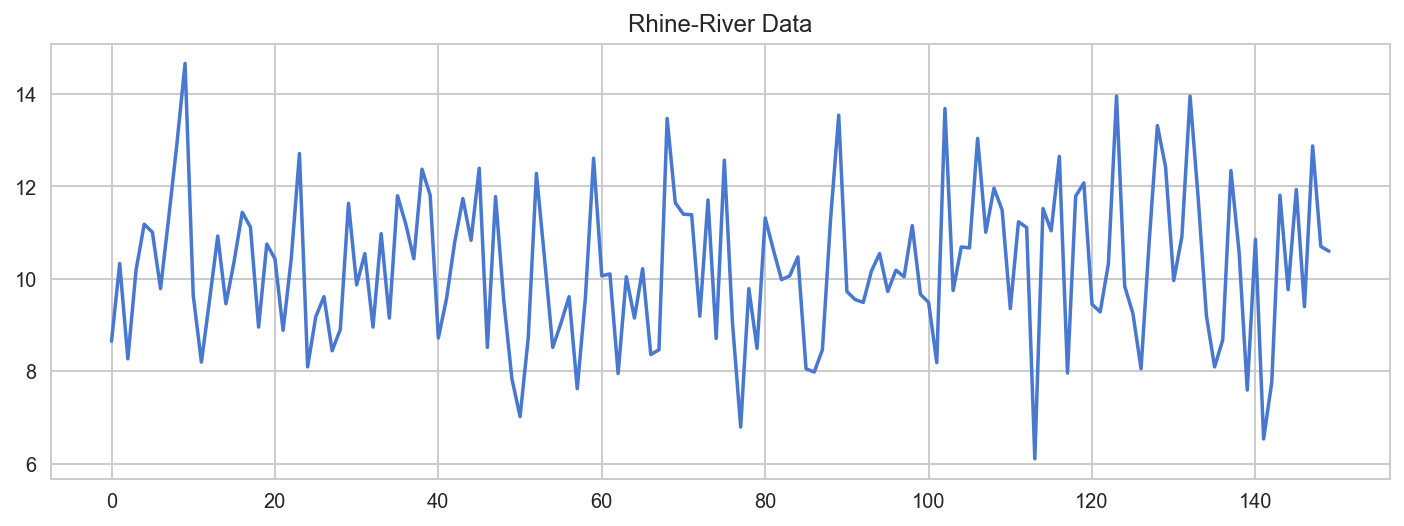

In [2]:
df = pd.read_csv("./data/rhine-river-near-basle-switzerla.csv")
df.columns = ["year", "data"]
# pre proceeding
df2 = df.data.values / 100
plt.figure(figsize = (12, 4))
plt.plot(df2, label = 'data')
plt.title("Rhine-River Data")
plt.show()

In [20]:
class ParticleSmoother(object):
    '''
    y : observation data
    n_particle : number of particles which use PF / PS
    mu_0 : mu for initial normal distribution
    sigma_0 : sigma for initial normal distribution
    sigma_2 : variance of observation noise
    alpha_2 : relatively variance = (variance of system noise) / (variance of observation noise)
    mu_0 : initial x_0 mean
    lag : smoother lag
    '''
    def __init__(self, y, n_particle = 1000, sigma_2 = 0.01, alpha_2 = 0.01, mu_0 = 0.0,
                 sigma_0 = 1, lag = 20):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.mu_0 = mu_0
        self.sigma_0 = sigma_0
        self.lag = lag
        #self.log_likelihood = - np.inf
    
    # likelihood for normal distribution
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2 * np.pi * s2))**(-1) * np.exp(-(y - x)**2 / (2 * s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k + 1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle)) # labelの生成
        k_list = np.zeros(self.n_particle, dtype = np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size = self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1 / self.n_particle)
        u = [1 / self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed = 71):
        '''
        T : length of y
        x : prediction distribution particles
        x_resampled : filter distribution particles
        initial_x : initial distribution of x
        w : weight lambda of each particle
        w_normed : normed weitht beta of each particle
        w_smoothed_normed : normed weithg beta of each smoothed particle
        x_smoothed : smoothed value x
        l : log likelihood for each time
        v : system noise particles
        k : index number for resampling
        '''
        rd.seed(seed)

        # number of time-series data
        T = len(self.y)
        
        # hidden variables
        x = np.zeros((T + 1, self.n_particle))
        x_resampled = np.zeros((T + 1, self.n_particle))
        
        # initial variables of x, x_resampled
        initial_x = rd.normal(self.mu_0, self.sigma_0, size = self.n_particle)
        x_resampled[0] = initial_x
        x[0] = initial_x

        # weight (likelihood)
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))
        w_smoothed_normed = np.zeros((T, self.n_particle))

        # smooth x
        x_smoothed = np.zeros((T + 1, self.n_particle))
        x_smoothed[0] = initial_x
        #filter_x = np.zeros((T + 1, self.n_particle))
        
        # log likelihood
        #l = np.zeros(T)

        for t in range(T):
            print("\r calculating... t={}".format(t + 1) + "/" + str(T), end="")
            for i in range(self.n_particle):
                # one-rank difference trend
                v = rd.normal(0, np.sqrt(self.alpha_2 * self.sigma_2)) # System Noise
                # system model
                x[t + 1, i] = x_resampled[t, i] + v
                # observation model
                w[t, i] = self.norm_likelihood(self.y[t], x[t + 1, i], self.sigma_2)
                # y[t]に対する各粒子の尤度
            w_normed[t] = w[t] / np.sum(w[t]) # 規格化
            #l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t])
            k = self.resampling2(w_normed[t])
            x_resampled[t + 1] = x[t + 1, k]
            x_smoothed[t + 1] = x_resampled[t + 1]
            
            # smoothing
            if (t > self.lag - 1) :
                x_smoothed[t - self.lag:t + 1] = x_smoothed[t - self.lag:t + 1, k]
                    
            
        # overall log likelihood
        #self.log_likelihood = np.sum(l) - T * np.log(n_particle)
        w_smoothed_normed[:T - self.lag] = w_normed[self.lag:]
        for t in range(T - lag, T)
            w_smoothed_normed[t] = w_normed[T - 1]
        
        self.x = x
        self.x_smoothed = x_smoothed
        self.x_resampled = x_resampled
        self.w_normed = w_normed
        self.w_smoothed_normed = w_smoothed_normed
        
        return x_smoothed, x_resampled, w_normed
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        return np.diag(np.dot(self.w_normed, self.x_resampled[1:].T))
    
    def get_smoothed_value(self) :
        return np.diag(np.dot(self.w_smoothed_normed, self.x_smoothed[1:].T))
    
    def get_smoothed_sd_value(self) :
        T = len(self.y)
        gsv = self.get_smoothed_value()
        sd_x_smoothed = (self.x_smoothed[1:].T - gsv)
        vd_x_smoothed = np.dot(sd_x_smoothed, sd_x_smoothed.T)
        return np.diag(np.dot(self.w_normed, vd_x_smoothed))
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y, "b", label = "Y")
        plt.plot(self.get_filtered_value(), color = "g", label = "PF")
        gsv = self.get_smoothed_value()
        plt.plot(gsv, color = "m", label = "PS")
        gssv = self.get_smoothed_sd_value()
        plt.plot(gsv + gssv, color = "y", label = "PS+sd")
        plt.plot(gsv - gssv, color = "y", label = "PS-sd")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2,
                        alpha = 0.1)
        
        plt.legend(loc = 'best')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.title("sigma^2={0}, alpha^2={1}".format(self.sigma_2, self.alpha_2))

SyntaxError: invalid syntax (<ipython-input-20-25148051631f>, line 123)

In [4]:
# ハイパーパラメーター
a = -2
b = -1
n_particle = 2**11
sigma_2 = 2**a
alpha_2 = 10**b
mu_0 = 9
sigma_0 = 1
lag = 20

In [5]:
ps = ParticleSmoother(df2, n_particle, sigma_2, alpha_2, mu_0, sigma_0, lag)
ps.simulate()

 calculating... t=150/150

(array([[  8.56939685,   7.80607191,   8.55570101, ...,   9.47348278,
           9.63030846,   9.16215246],
        [  8.32567264,   8.32567264,   8.32567264, ...,   9.50627457,
           9.50627457,   9.50627457],
        [  9.58728862,   9.58728862,   9.58728862, ...,   9.43743434,
           9.43743434,   9.43743434],
        ..., 
        [ 10.20987566,  10.54062386,  10.54062386, ...,  10.69867429,
          10.69867429,  10.1434388 ],
        [  9.97377144,  10.80577993,  10.60438143, ...,  10.87057067,
          10.2618698 ,  10.49123375],
        [  9.79983854,  10.97421486,  10.53656283, ...,  10.43158338,
          10.77312726,  10.3605276 ]]),
 array([[  8.56939685,   7.80607191,   8.55570101, ...,   9.63030846,
           9.16215246,   9.10583222],
        [  8.32567264,   8.32567264,   7.83089849, ...,   9.03893921,
           9.03893921,   9.12897022],
        [  9.58728862,   9.58728862,   9.58728862, ...,   9.03041025,
           9.1696326 ,   9.1696326 ],
        ...,

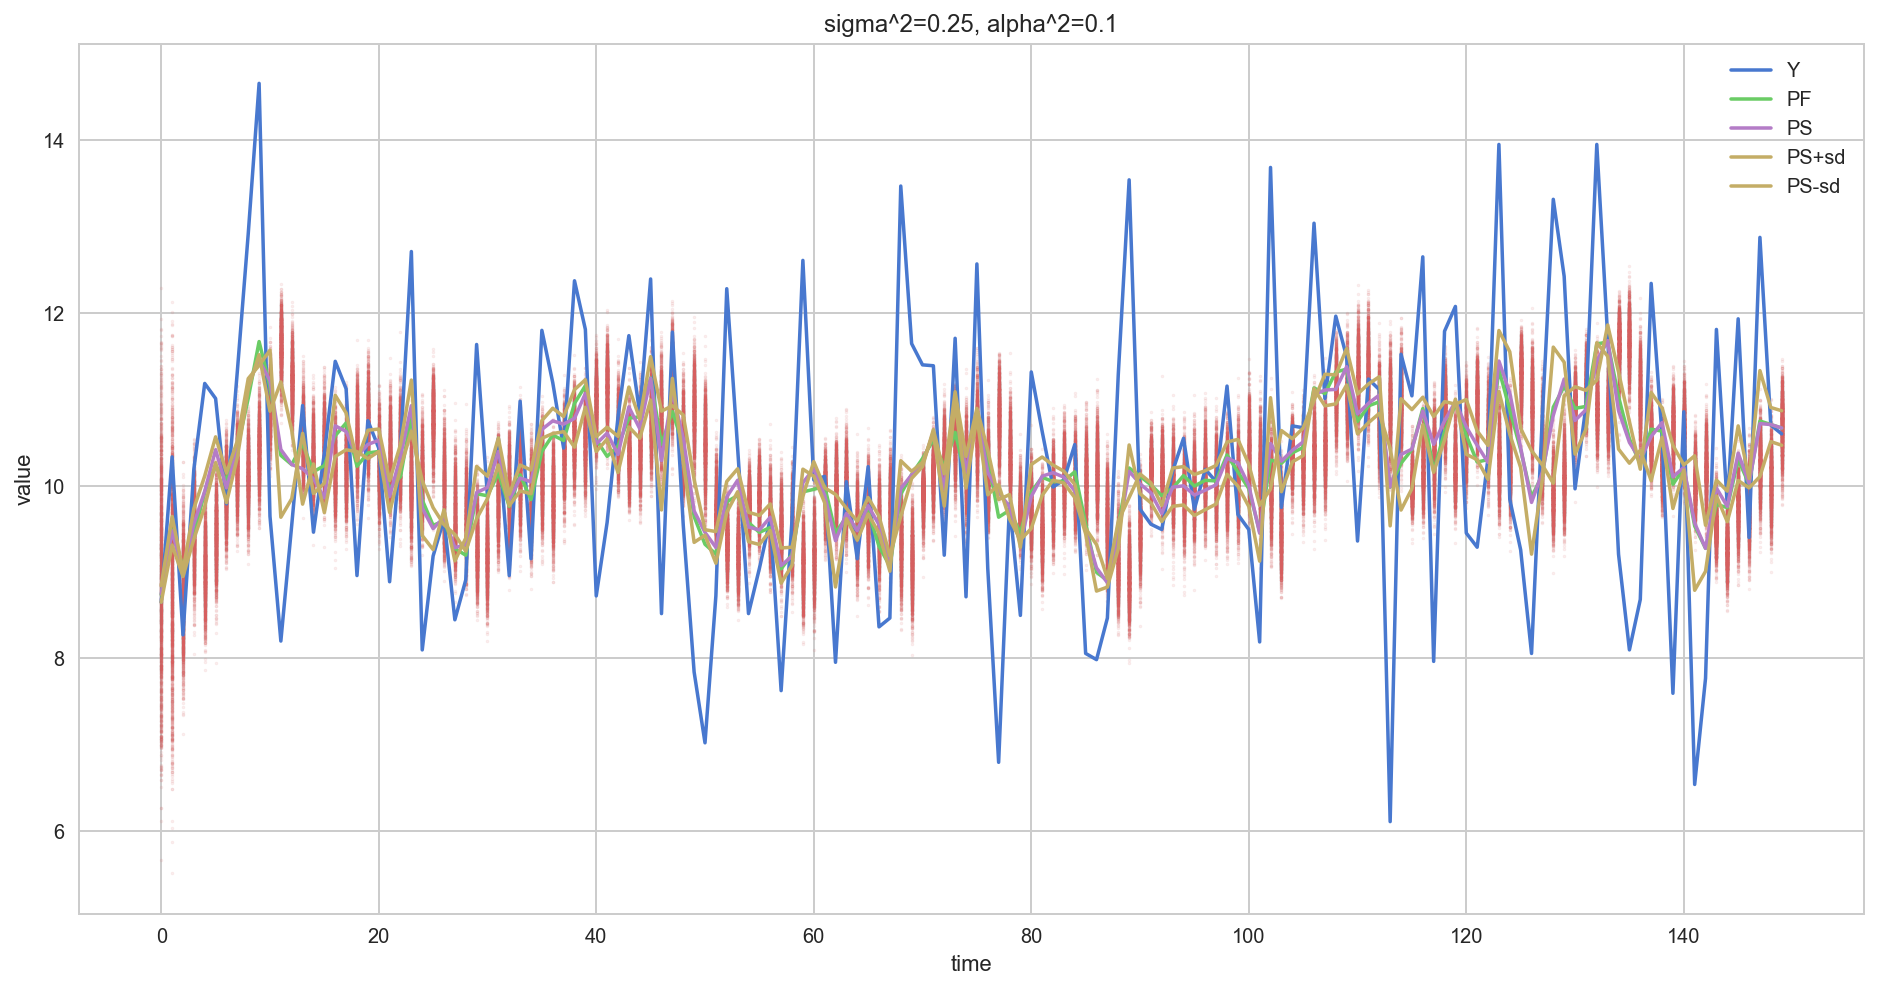

In [6]:
ps.draw_graph()
plt.savefig("plot/171023_particle_smoothing_rhine_lag20_withsd.png")
plt.show()

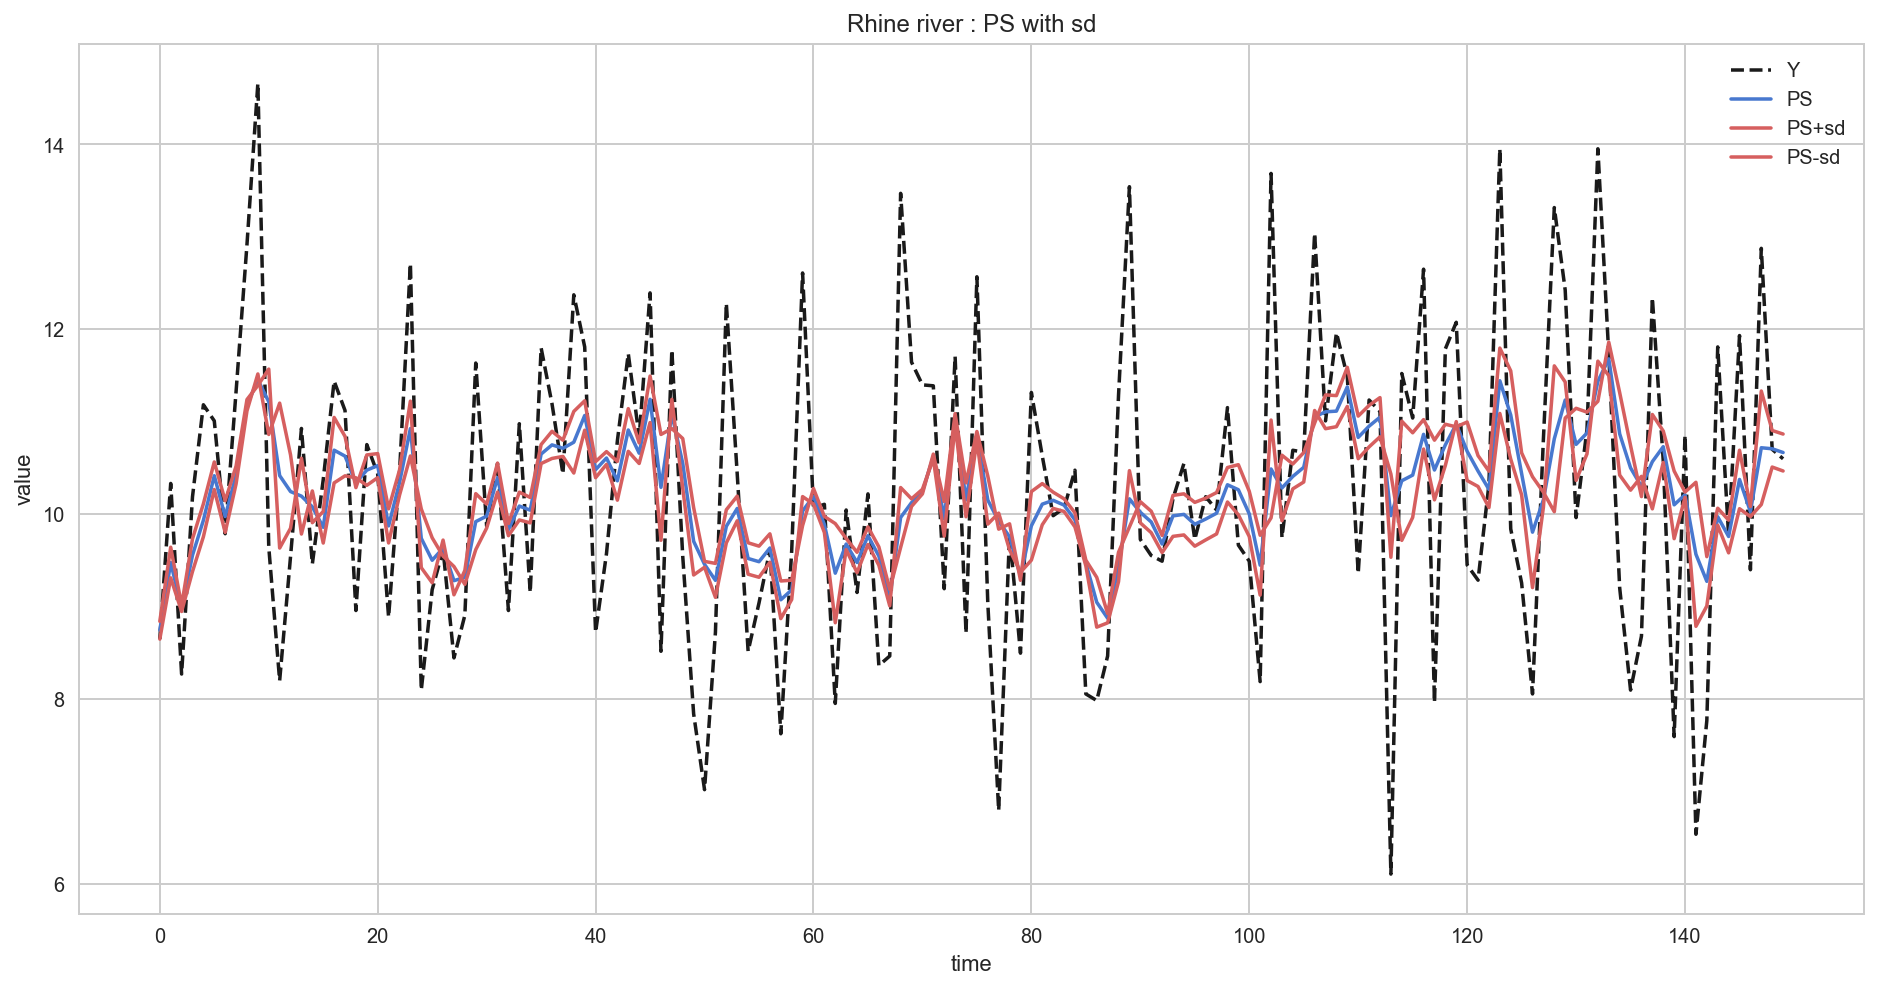

In [8]:
T = len(ps.y)
 
plt.figure(figsize=(16,8))
plt.plot(range(T), ps.y, color = "k", linestyle = "--", label = "Y")
#plt.plot(self.get_filtered_value(), color = "g", label = "PF")
gsv = ps.get_smoothed_value()
plt.plot(gsv, color = "b", label = "PS")
gssv = ps.get_smoothed_sd_value()
plt.plot(gsv + gssv, color = "r", label = "PS+sd")
plt.plot(gsv - gssv, color = "r", label = "PS-sd")

plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("Rhine river : PS with sd")
plt.savefig("plot/171023_particle_smoothing_rhine_withsd.png")

標準偏差取っておきながら，最初に前処理で100で割ってるのでまあ適当なライン

## カルマンスムージング（KS）

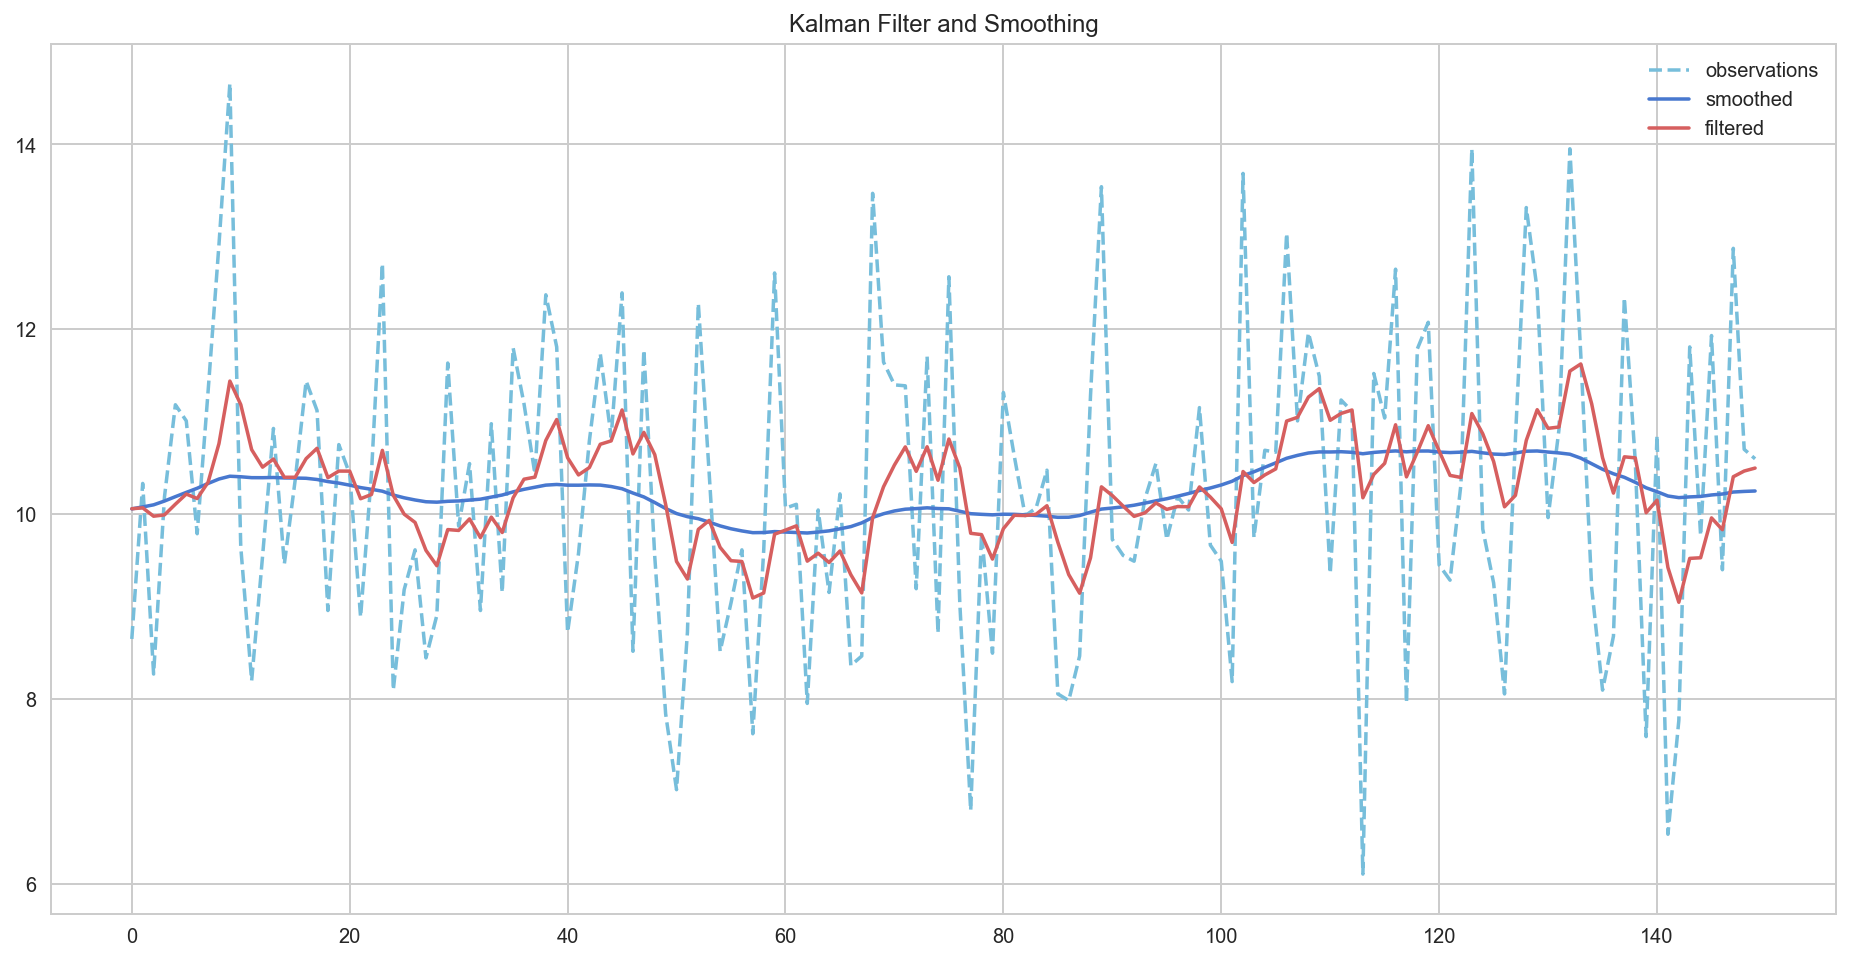

In [9]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = np.array([[1, 1], [0, 1]]),
                  transition_covariance = 0.0000001*np.eye(2))

kalman_smooth_x = kf.em(df2).smooth(df2)[0]
kalman_filter_x = kf.em(df2).filter(df2)[0]

plt.figure(figsize=(16, 8))
plt.plot(df2, "-xc", linestyle = "--", label="observations")
plt.plot(kalman_smooth_x[:, 0], "b", label="smoothed")
plt.plot(kalman_filter_x[:, 0], "r", label="filtered")
#plt.axhline(x, color="k", label="truth value")
plt.legend(loc = 'best')
plt.title('Kalman Filter and Smoothing')
plt.savefig('plot/171023_kalman_smoothing_rhine.png')
plt.show()

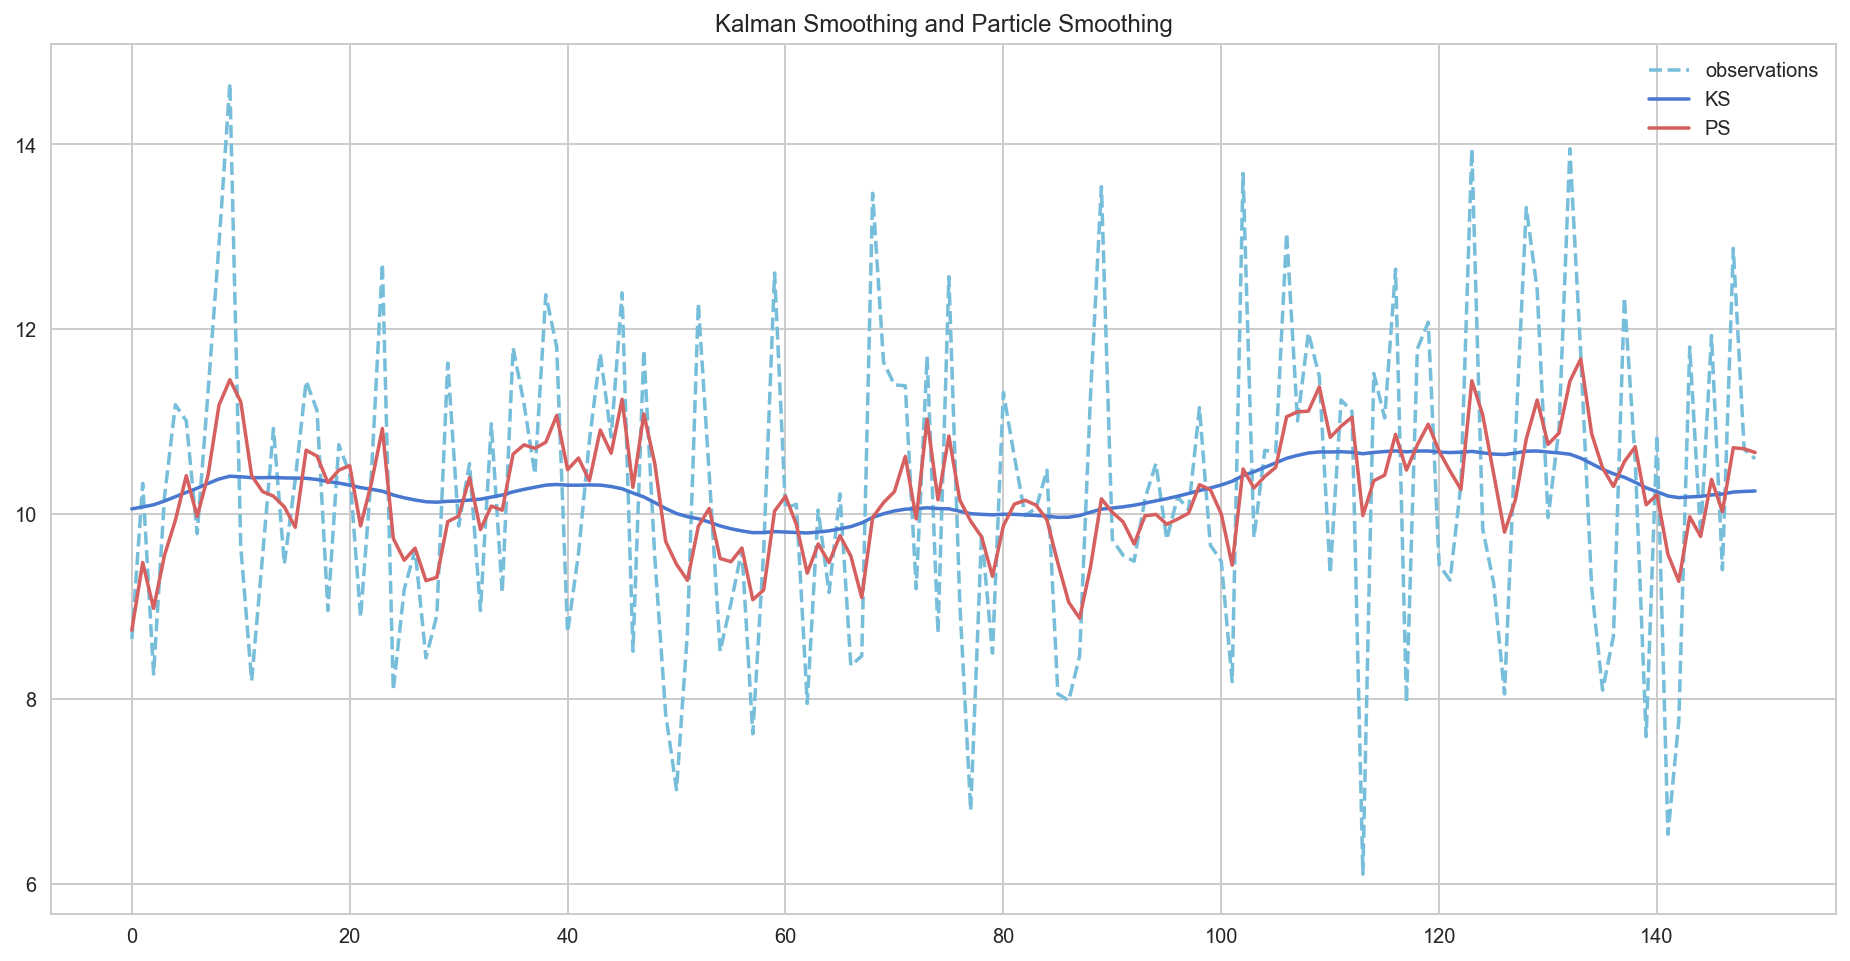

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(df2, "-xc", linestyle = "--", label="observations")
plt.plot(kalman_smooth_x[:, 0], "b", label="KS")
plt.plot(ps.get_smoothed_value(), "r", label = "PS")
plt.legend(loc = 'best')
plt.title('Kalman Smoothing and Particle Smoothing')
plt.savefig('plot/171023_particle_smoothing_rhine_with_KS.png')
plt.show()

粒子スムージングがあまりスムージングされていない疑惑．<br>
ラグが20しかないからかどうか．

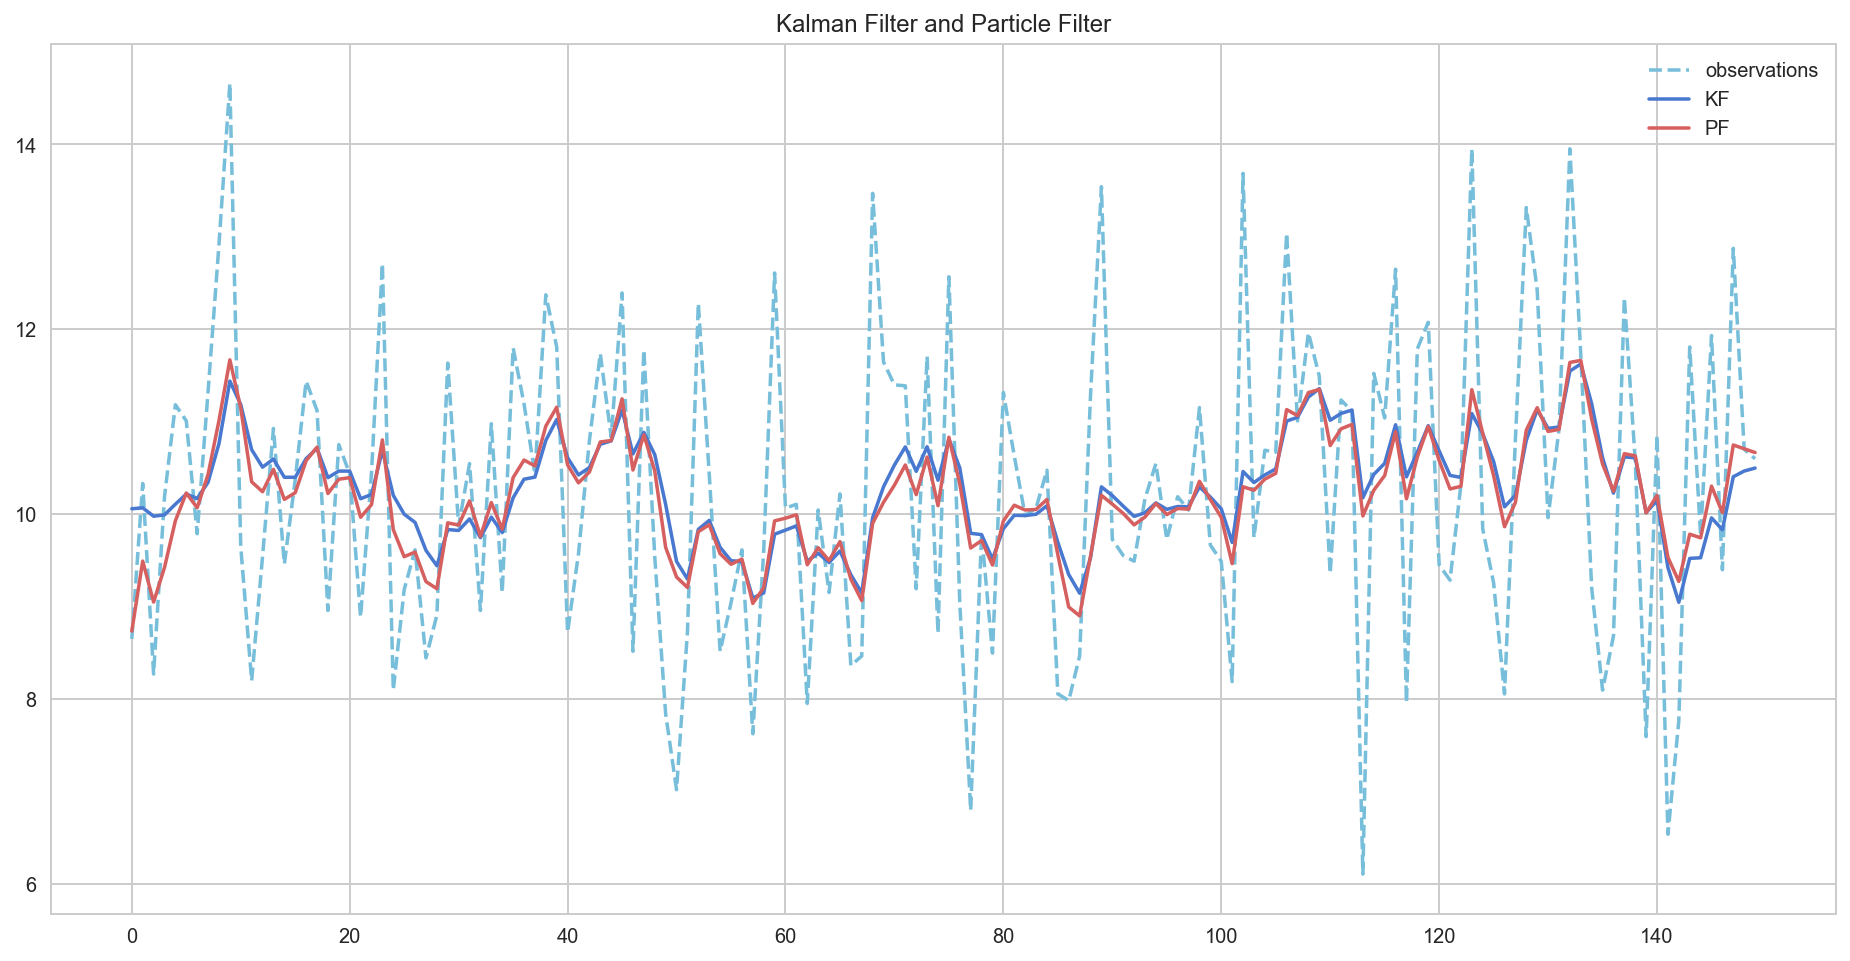

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(df2, "-xc", linestyle = "--", label="observations")
plt.plot(kalman_filter_x[:, 0], "b", label="KF")
plt.plot(ps.get_filtered_value(), "r", label = "PF")
plt.legend(loc = 'best')
plt.title('Kalman Filter and Particle Filter')
plt.savefig('plot/171023_particle_filtering_rhine_with_KF.png')
plt.show()

フィルターはほとんどKFとPF一致している．粒子の退化は見当たらない．

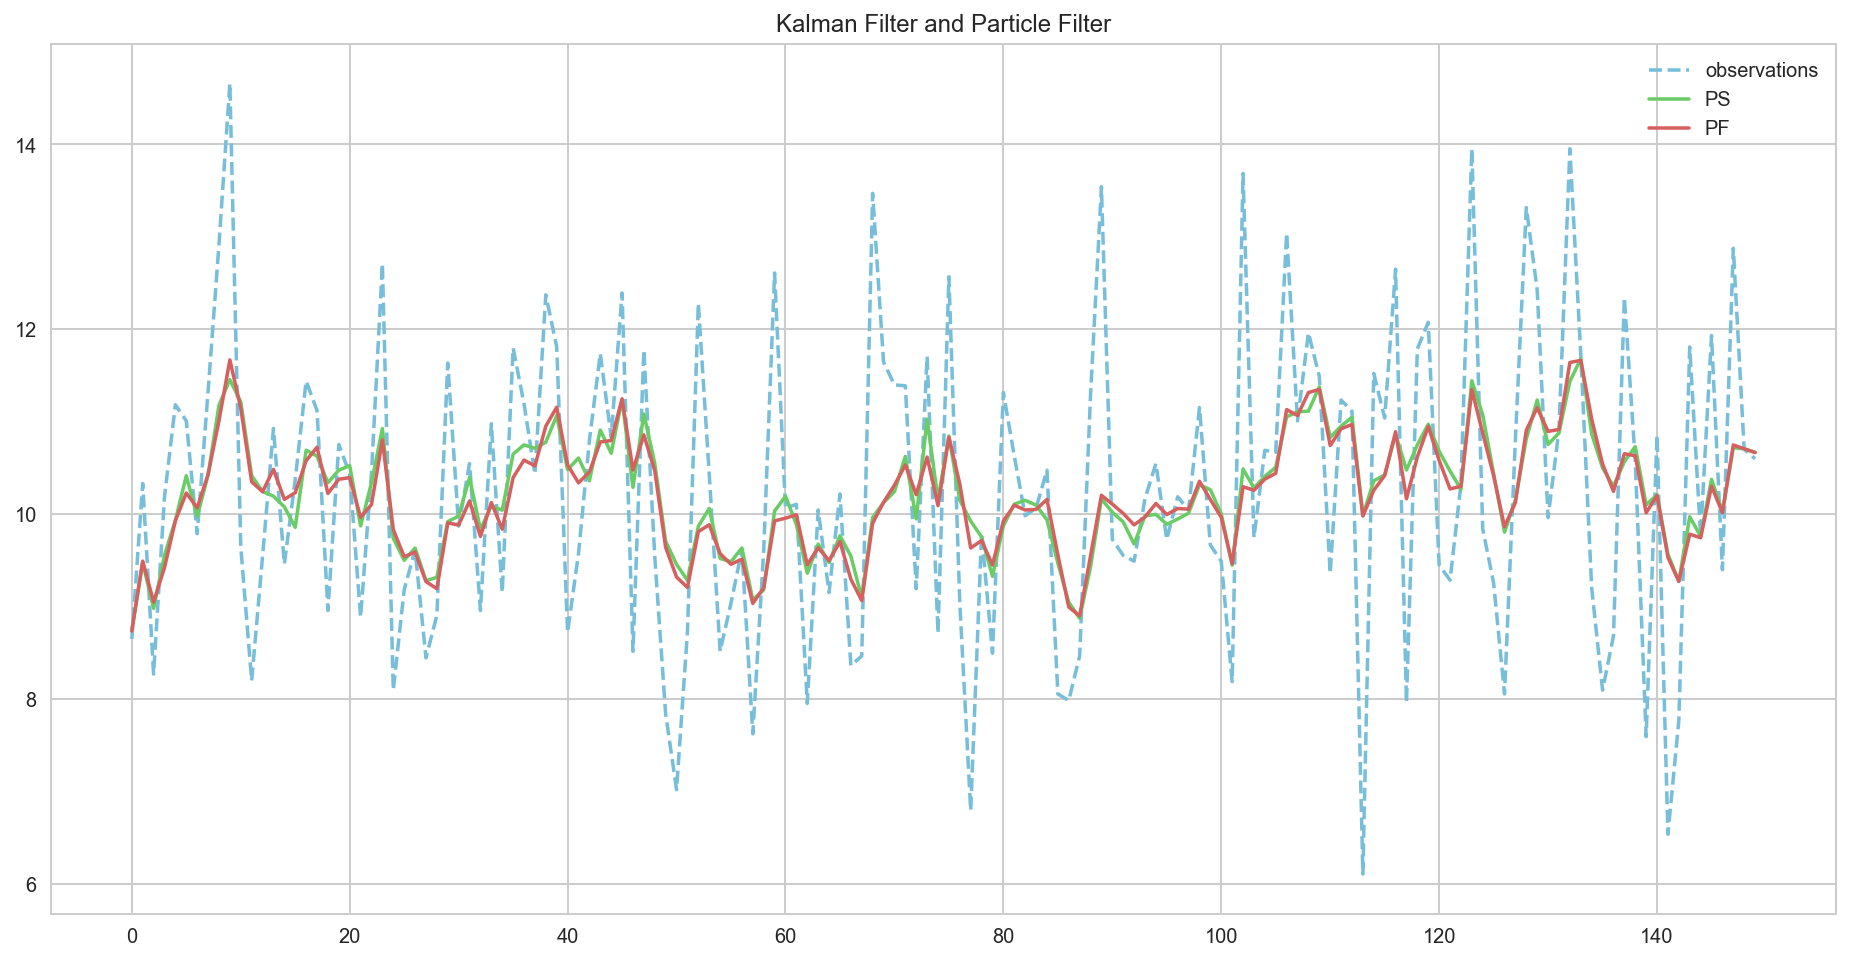

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(df2, "-xc", linestyle = "--", label="observations")
plt.plot(ps.get_smoothed_value(), "g", label="PS")
plt.plot(ps.get_filtered_value(), "r", label = "PF")
plt.legend(loc = 'best')
plt.title('Kalman Filter and Particle Filter')
plt.savefig('plot/171023_particle_smoothing_rhine_with_PF_lag20.png')
plt.show()

粒子フィルタと粒子スムージングの振る舞いがほぼ変わらない．<br>
あまりsmoothingされてる感じがしない．lagを30ぐらいにしてみる．

In [21]:
# ハイパーパラメーター
a = -2
b = -1
n_particle = 2**11
sigma_2 = 2**a
alpha_2 = 10**b
mu_0 = 9
sigma_0 = 1
lag = 20

In [22]:
ps = ParticleSmoother(df2, n_particle, sigma_2, alpha_2, mu_0, sigma_0, lag)
ps.simulate()

 calculating... t=150/150

(array([[  8.56939685,   7.80607191,   8.55570101, ...,   9.47348278,
           9.63030846,   9.16215246],
        [  8.32567264,   8.32567264,   8.32567264, ...,   9.50627457,
           9.50627457,   9.50627457],
        [  9.58728862,   9.58728862,   9.58728862, ...,   9.43743434,
           9.43743434,   9.43743434],
        ..., 
        [ 10.20987566,  10.54062386,  10.54062386, ...,  10.69867429,
          10.69867429,  10.1434388 ],
        [  9.97377144,  10.80577993,  10.60438143, ...,  10.87057067,
          10.2618698 ,  10.49123375],
        [  9.79983854,  10.97421486,  10.53656283, ...,  10.43158338,
          10.77312726,  10.3605276 ]]),
 array([[  8.56939685,   7.80607191,   8.55570101, ...,   9.63030846,
           9.16215246,   9.10583222],
        [  8.32567264,   8.32567264,   7.83089849, ...,   9.03893921,
           9.03893921,   9.12897022],
        [  9.58728862,   9.58728862,   9.58728862, ...,   9.03041025,
           9.1696326 ,   9.1696326 ],
        ...,